In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

from gr6j import Catchment, CemaNeige, ForcingData, ObservedData, Parameters, calibrate, run
from gr6j.utils import CaravanDataSource, analyze_dem, compute_mean_annual_solid_precip

sns.set_context("paper", font_scale=1.3)

In [2]:
GAUGE_ID = "camels_06224000"
DEM_PATH = f"/Users/nicolaslazaro/Desktop/work/GR6J/data/mountainous-us-basins/REGION_NAME=camels/data_type=DEM/{GAUGE_ID}_DEM.tif"

In [3]:
dem = analyze_dem(DEM_PATH)

In [4]:
data_source = "/Users/nicolaslazaro/Desktop/work/GR6J/data/mountainous-us-basins"

caravan_ds = CaravanDataSource(data_source)

In [5]:
# precipitation: mswep_precipitation
# pet: potential_evaporation_sum_FAO_PENMAN_MONTEITH
# temperature: temperature_2m_mean
# observed discharge: streamflow

time_series = caravan_ds.get_timeseries(gauge_ids=[GAUGE_ID], columns=[
    "era5_land_precipitation_multimet",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "streamflow"
]).collect()

print(time_series.head())

shape: (5, 7)
┌────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────────┐
│ date       ┆ temperature_ ┆ potential_ev ┆ era5_land_pr ┆ streamflow ┆ REGION_NAME ┆ gauge_id    │
│ ---        ┆ 2m_mean      ┆ aporation_su ┆ ecipitation_ ┆ ---        ┆ ---         ┆ ---         │
│ date       ┆ ---          ┆ m_FAO_…      ┆ multim…      ┆ f64        ┆ str         ┆ str         │
│            ┆ f64          ┆ ---          ┆ ---          ┆            ┆             ┆             │
│            ┆              ┆ f64          ┆ f64          ┆            ┆             ┆             │
╞════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│ 1981-01-01 ┆ -3.698055    ┆ 0.0          ┆ 0.003369     ┆ 0.135784   ┆ camels      ┆ camels_0622 │
│            ┆              ┆              ┆              ┆            ┆             ┆ 4000        │
│ 1981-01-02 ┆ -3.774812    ┆ 0.201516     ┆ 0.00087      ┆ 0.130755   ┆ came

In [6]:
# Schema([('date', Date),
#         ('temperature_2m_mean', Float64),
#         ('potential_evaporation_sum_FAO_PENMAN_MONTEITH', Float64),
#         ('mswep_precipitation', Float64),
#         ('streamflow', Float64),
#         ('REGION_NAME', String),
#         ('gauge_id', String)])


forcing = ForcingData(
    time=np.array(time_series["date"]),
    precip=np.array(time_series["era5_land_precipitation_multimet"]),
    pet=np.array(time_series["potential_evaporation_sum_FAO_PENMAN_MONTEITH"]),
    temp=np.array(time_series["temperature_2m_mean"]),
)

print(len(forcing))

12333


In [7]:
snow = CemaNeige(
    ctg=0.97,  # Thermal state coefficient [-]
    kf=2.5,  # Degree-day melt factor [mm/deg C/day]
)

catchment = Catchment(
    mean_annual_solid_precip=compute_mean_annual_solid_precip(forcing.precip, forcing.temp),
    hypsometric_curve=dem.hypsometric_curve,
    input_elevation=dem.median_elevation,
    n_layers=5
)

params = Parameters(
    x1=350.0,  # Production store capacity [mm]
    x2=0.0,  # Intercatchment exchange coefficient [mm/day]
    x3=90.0,  # Routing store capacity [mm]
    x4=1.7,  # Unit hydrograph time constant [days]
    x5=0.0,  # Intercatchment exchange threshold [-]
    x6=5.0,  # Exponential store scale parameter [mm]
    snow=snow,
)

# Run the model
output = run(params, forcing, catchment=catchment)

# Access streamflow
print(output.gr6j.streamflow)

[4.14262046 2.65663924 2.02686439 ... 0.87415951 0.83916738 0.80669506]


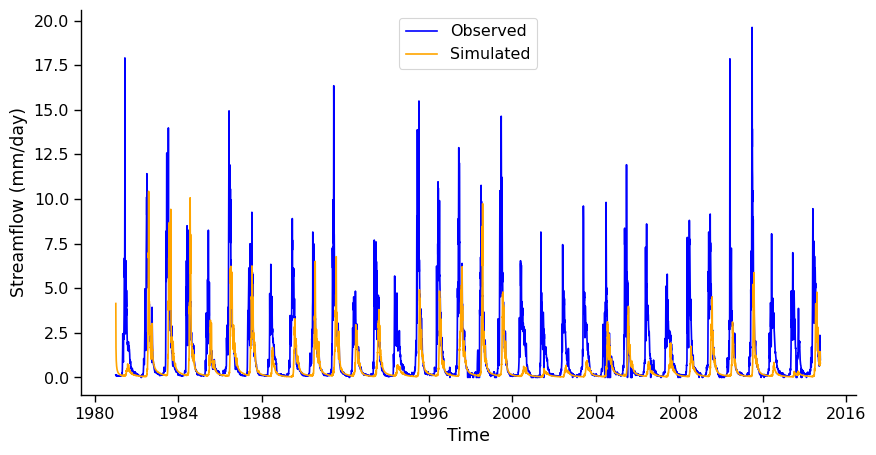

In [8]:
observations = np.array(time_series["streamflow"])

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(forcing.time, observations, label="Observed", color="blue")
plt.plot(forcing.time, output.gr6j.streamflow, label="Simulated", color="orange")
plt.xlabel("Time")
plt.ylabel("Streamflow (mm/day)")
plt.legend()
sns.despine()
plt.show()

In [9]:
warmup_period = 365  # days

observed = ObservedData(
    time=np.array(time_series["date"])[warmup_period:],
    streamflow=np.array(time_series["streamflow"])[warmup_period:],
)

bounds = {
    "x1": (50, 2000),
    "x2": (-10, 5),
    "x3": (10, 500),
    "x4": (0.5, 15),
    "x5": (-1, 1),
    "x6": (0.01, 50),
    "ctg": (0, 1),
    "kf": (1, 10),
}

In [ ]:
result = calibrate(
    model="gr6j_cemaneige",  # 8-parameter model with snow module
    forcing=forcing,
    observed=observed,
    objectives=["nse", "log_nse"],
    bounds=bounds,
    warmup=warmup_period,
    population_size=100,
    generations=100,
    seed=42,
    catchment=catchment,
    n_workers=-1
)

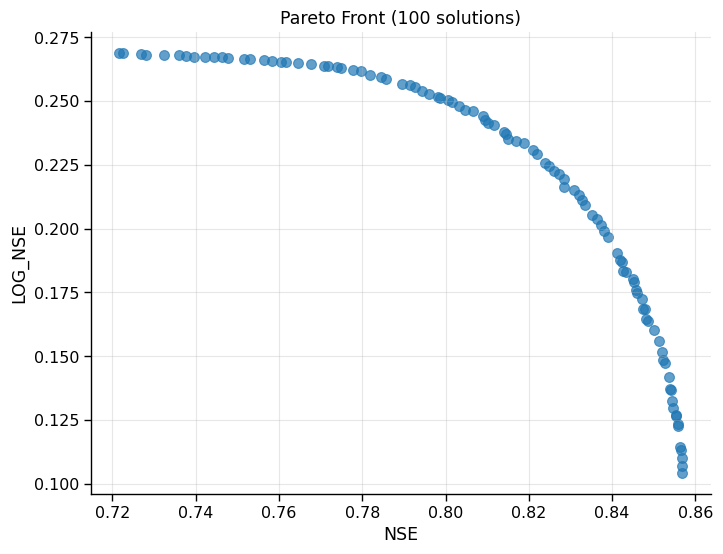

Best NSE: 0.857 (log_nse: 0.104)
Best log_nse: 0.269 (nse: 0.722)


In [18]:
# result is a list of Solutions for multi-objective
solutions = result  # rename for clarity

# Extract scores for plotting
nse_scores = [sol.score["nse"] for sol in solutions]
log_nse_scores = [sol.score["log_nse"] for sol in solutions]

# Plot Pareto front
plt.figure(figsize=(8, 6))
plt.scatter(nse_scores, log_nse_scores, s=50, alpha=0.7)
plt.xlabel("NSE")
plt.ylabel("LOG_NSE")
plt.title(f"Pareto Front ({len(solutions)} solutions)")
plt.grid(True, alpha=0.3)
sns.despine()
plt.show()

# Print best for each objective
best_nse = max(solutions, key=lambda s: s.score["nse"])
best_log_nse = max(solutions, key=lambda s: s.score["log_nse"])
print(f"Best NSE: {best_nse.score['nse']:.3f} (log_nse: {best_nse.score['log_nse']:.3f})")
print(f"Best log_nse: {best_log_nse.score['log_nse']:.3f} (nse: {best_log_nse.score['nse']:.3f})")

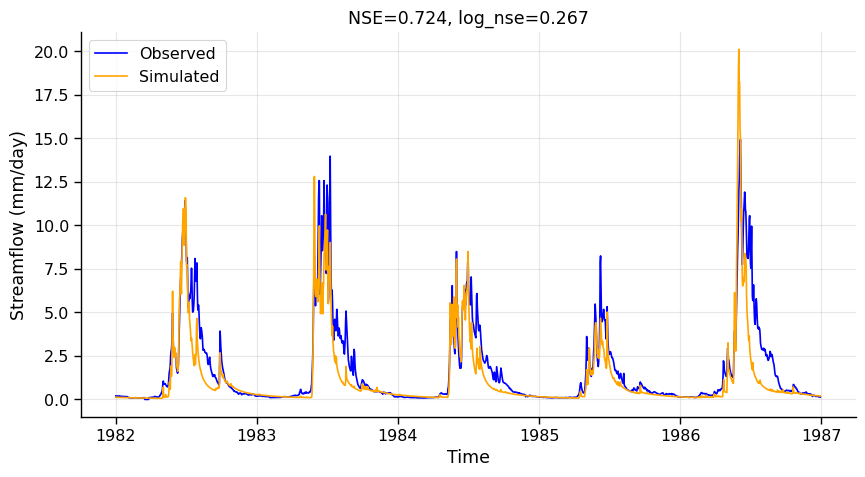

In [16]:
best = max(solutions, key=lambda s: s.score["log_nse"])
output = run(best.parameters, forcing, catchment=catchment)

plt.figure(figsize=(10, 5))
plt.plot(forcing.time[365:365*6], observations[365:365*6], label="Observed", color="blue")
plt.plot(forcing.time[365:365*6], output.gr6j.streamflow[365:365*6], label="Simulated", color="orange")
plt.xlabel("Time")
plt.ylabel("Streamflow (mm/day)")
plt.title(f"NSE={best.score['nse']:.3f}, log_nse={best.score['log_nse']:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
sns.despine()
plt.show()

In [ ]:
# output = run(result.parameters, forcing, catchment=catchment)

# plt.figure(figsize=(10, 5))
# plt.plot(forcing.time[365:365*6], observations[365:365*6], label="Observed", color="blue")
# plt.plot(forcing.time[365:365*6], output.gr6j.streamflow[365:365*6], label="Simulated", color="orange")
# plt.xlabel("Time")
# plt.ylabel("Streamflow (mm/day)")
# plt.legend()
# plt.grid(True, alpha=0.3)
# sns.despine()
# plt.show()

In [ ]:
# # plot QQ plot

# plt.figure(figsize=(6, 6))
# sorted_obs = np.sort(observations[warmup_period:])
# sorted_sim = np.sort(output.gr6j.streamflow[warmup_period:])
# plt.scatter(sorted_obs, sorted_sim, alpha=0.5)
# max_val = max(sorted_obs.max(), sorted_sim.max())
# plt.plot([0, max_val], [0, max_val], color="red", linestyle="--")
# plt.xlabel("Observed Streamflow (mm/day)")
# plt.ylabel("Simulated Streamflow (mm/day)")
# plt.title("QQ Plot of Observed vs Simulated Streamflow")
# sns.despine()
# plt.show()

